In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN, convert_feature_into_cyclic
from sklearn.preprocessing import RobustScaler

raw_data = pd.read_csv('../csvs/household_power_consumption.txt', sep=';', dtype={'Global_active_power': 'float32',
                                                                                  'Global_reactive_power': 'float32',
                                                                                  'Voltage': 'float32',
                                                                                  'Global_intensity': 'float32',
                                                                                  'Sub_metering_1': 'float32',
                                                                                  'Sub_metering_2': 'float32',
                                                                                  'Sub_metering_3': 'float32'}, na_values=['?'])

SUBSET = 120000
raw_data = raw_data[:SUBSET]

raw_data = raw_data.dropna(how='any')
raw_data['DateTime'] = pd.to_datetime(raw_data['Date'] + ' ' + raw_data['Time'], format='%d/%m/%Y %H:%M:%S')
raw_data.drop(columns=['Date', 'Time'], inplace=True)
raw_data.sort_values(by='DateTime', inplace=True)
raw_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,2006-12-16 17:28:00
...,...,...,...,...,...,...,...,...
119995,0.260,0.000,244.589996,1.0,0.0,0.0,0.0,2007-03-10 01:19:00
119996,0.224,0.000,244.229996,1.0,0.0,0.0,0.0,2007-03-10 01:20:00
119997,0.224,0.000,243.410004,1.0,0.0,0.0,0.0,2007-03-10 01:21:00
119998,0.226,0.000,244.320007,1.0,0.0,0.0,0.0,2007-03-10 01:22:00


In [25]:
corr = raw_data.corr()
corr[abs(corr) > 0.5]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
Global_active_power,1.000000,NaN,-0.611969,0.999037,NaN,NaN,0.574304,NaN
Global_reactive_power,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Voltage,-0.611969,NaN,1.000000,-0.617647,NaN,NaN,NaN,NaN
Global_intensity,0.999037,NaN,-0.617647,1.000000,NaN,NaN,0.564990,NaN
Sub_metering_1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Sub_metering_2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Sub_metering_3,0.574304,NaN,NaN,0.564990,NaN,NaN,1.000000,NaN
DateTime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [26]:
(raw_data == None).sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
DateTime                 0
dtype: int64

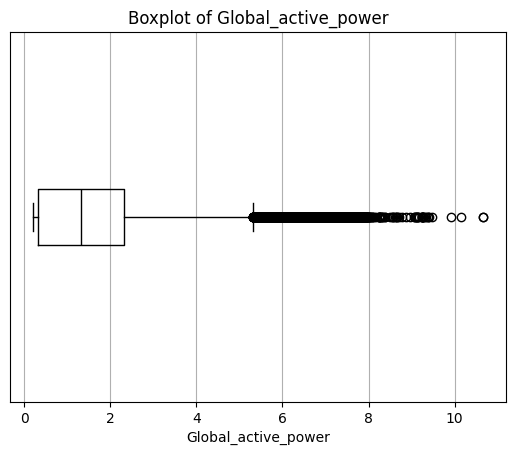

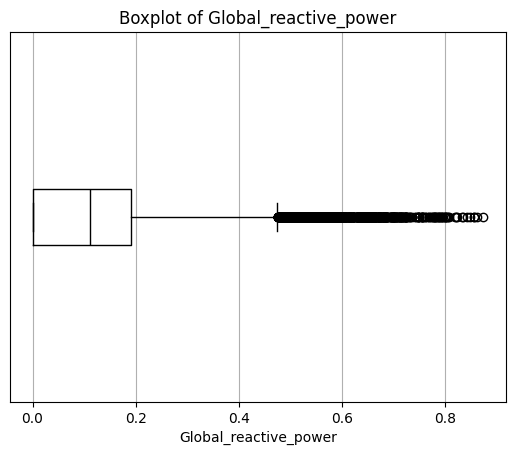

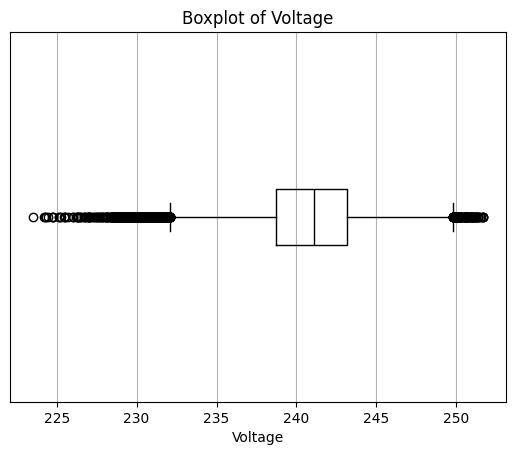

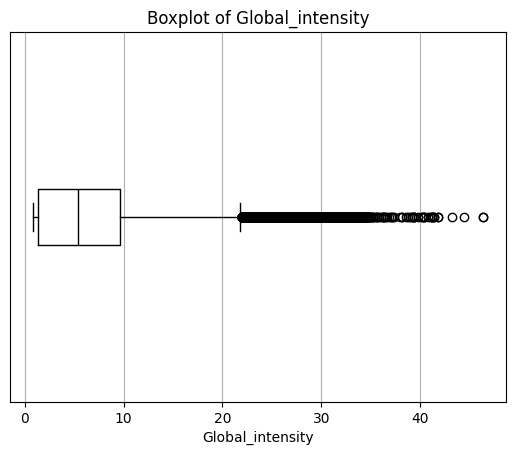

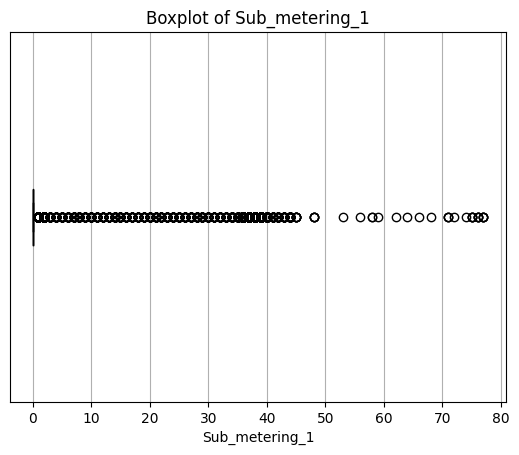

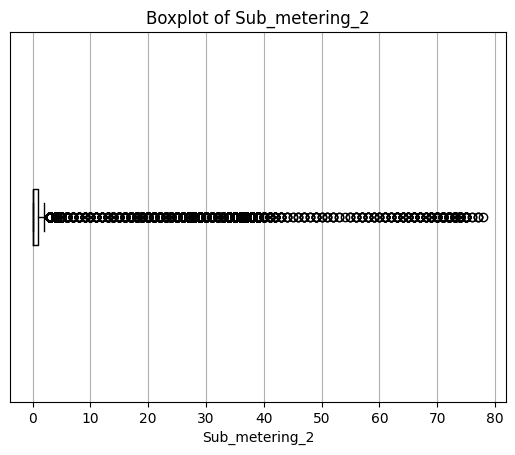

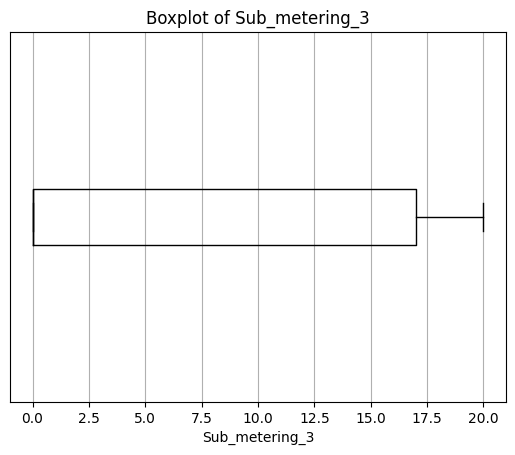

In [27]:
from util import plot_feature_over_time
from util import plot_boxplot_of_feature

plot_boxplot_of_feature(data=raw_data, feature='Global_active_power')
plot_boxplot_of_feature(data=raw_data, feature='Global_reactive_power')
plot_boxplot_of_feature(data=raw_data, feature='Voltage')
plot_boxplot_of_feature(data=raw_data, feature='Global_intensity')
plot_boxplot_of_feature(data=raw_data, feature='Sub_metering_1')
plot_boxplot_of_feature(data=raw_data, feature='Sub_metering_2')
plot_boxplot_of_feature(data=raw_data, feature='Sub_metering_3')

In [28]:
split_index = int(len(raw_data) * 0.7)
raw_train = raw_data[:split_index]
raw_test = raw_data[split_index:]

In [29]:
def preprocess_data(raw_data):
    data = raw_data.copy()
    # Dropped because it is highly correlated
    data.drop(columns=['Global_intensity'], inplace=True)
    data['Hour'] = data['DateTime'].dt.hour
    data['DayOfMonth'] = data['DateTime'].dt.day
    data['DayOfWeek'] = data['DateTime'].dt.dayofweek
    #data['Month'] = data['DateTime'].dt.month
    #data['DayOfYear'] = data['DateTime'].dt.dayofyear
    data['WeekOfYear'] = data['DateTime'].dt.isocalendar().week.astype(int)
    data = convert_feature_into_cyclic(data, 'Hour', 24)
    data = convert_feature_into_cyclic(data, 'DayOfMonth', 31)
    data = convert_feature_into_cyclic(data, 'DayOfWeek', 7)
    #data = convert_feature_into_cyclic(data, 'Month', 12)
    #data = convert_feature_into_cyclic(data, 'DayOfYear', 365)
    data = convert_feature_into_cyclic(data, 'WeekOfYear', 52)
    data.drop(columns=['Hour', 'DayOfMonth', 'DayOfWeek', 'WeekOfYear'], inplace=True)
    numerical_features = list(data.select_dtypes(include=['float32']).columns)
    numerical_features.remove('Global_active_power')
    print(numerical_features)
    for feature in numerical_features:
        data['Log'+feature] = np.log1p(1+data[feature])
        data.drop(columns=[feature], inplace=True)
        # Global_intensity dropped because it is corr
    data.drop(columns=['DateTime'], inplace=True)
    return data

preprocessed_train = preprocess_data(raw_train)
preprocessed_train

['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


,Global_active_power,HourSin,HourCos,DayOfMonthSin,DayOfMonthCos,DayOfWeekSin,DayOfWeekCos,WeekOfYearSin,WeekOfYearCos,LogGlobal_reactive_power,LogVoltage,LogSub_metering_1,LogSub_metering_2,LogSub_metering_3
0,4.216,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.882941,5.467385,0.693147,1.098612,2.944439
1,5.360,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.890357,5.462263,0.693147,1.098612,2.890372
2,5.374,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.915490,5.460819,0.693147,1.386294,2.944439
3,5.388,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.917090,5.462729,0.693147,1.098612,2.944439
4,3.666,-0.965926,-0.258819,-0.101168,-0.994869,-0.974928,-0.222521,-0.239316,0.970942,0.927428,5.470925,0.693147,1.098612,2.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83995,0.468,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.855266,5.499542,0.693147,1.386294,0.693147
83996,0.402,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.811819,5.499379,0.693147,1.098612,0.693147
83997,0.394,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.805583,5.494172,0.693147,1.386294,0.693147
83998,0.394,0.258819,0.965926,0.485302,-0.874347,0.781831,0.623490,0.748511,0.663123,0.804689,5.493103,0.693147,1.098612,0.693147


In [30]:
corr = preprocessed_train.corr()
corr[abs(corr) > 0.5]

,Global_active_power,HourSin,HourCos,DayOfMonthSin,DayOfMonthCos,DayOfWeekSin,DayOfWeekCos,WeekOfYearSin,WeekOfYearCos,LogGlobal_reactive_power,LogVoltage,LogSub_metering_1,LogSub_metering_2,LogSub_metering_3
Global_active_power,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.639272,NaN,NaN,0.554426
HourSin,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HourCos,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfMonthSin,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfMonthCos,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekSin,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekCos,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WeekOfYearSin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,-0.89896,NaN,NaN,NaN,NaN,NaN
WeekOfYearCos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.89896,1.00000,NaN,NaN,NaN,NaN,NaN
LogGlobal_reactive_power,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


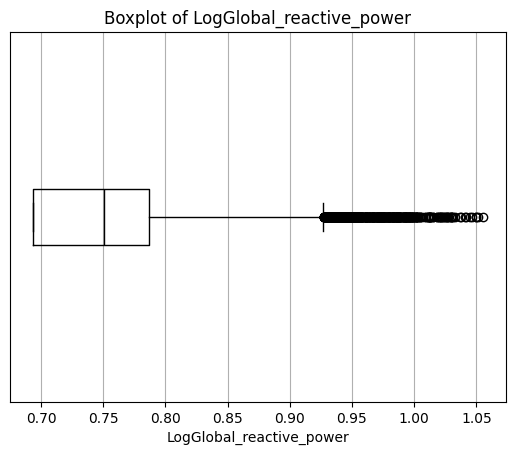

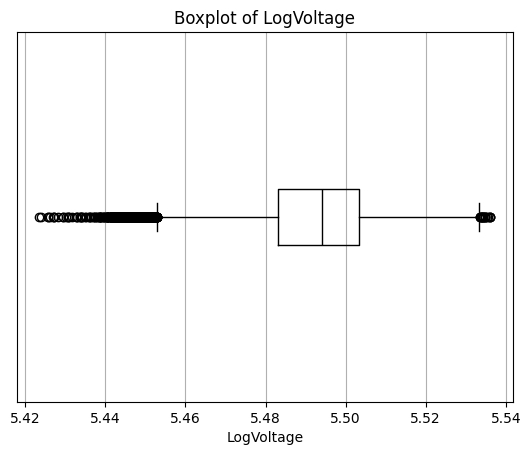

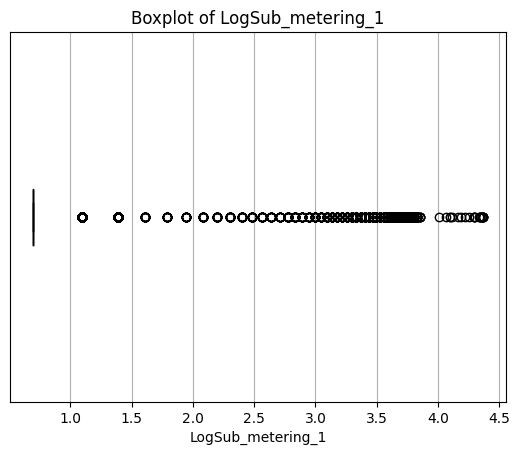

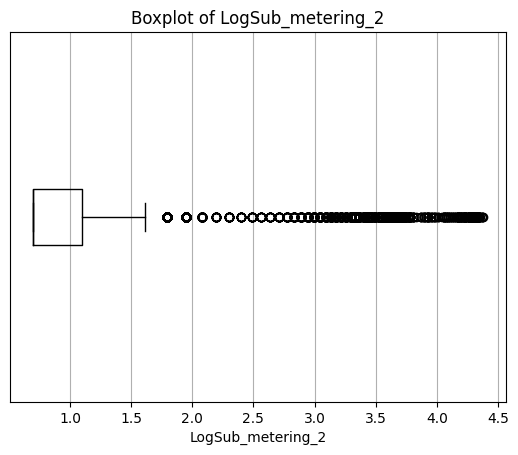

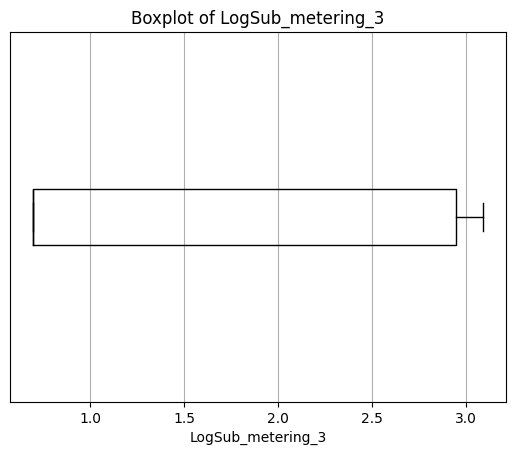

In [31]:
features_to_show = ['LogGlobal_reactive_power', 'LogVoltage', 'LogSub_metering_1', 'LogSub_metering_2', 'LogSub_metering_3']

for feature in features_to_show:
    plot_boxplot_of_feature(data=preprocessed_train, feature=feature)

(83994, 13)
(83994,)
(83931, 64, 13)
(83931,)
Train indices from 0 to 16786 and validation indices from 16787 to 33572
Epoch [1/100], Loss: 2.5901, Validation Loss: 1.3267, Squareroot of Validation Loss: 1.1518
Epoch [2/100], Loss: 1.5179, Validation Loss: 1.1953, Squareroot of Validation Loss: 1.0933
Epoch [3/100], Loss: 1.1937, Validation Loss: 1.3402, Squareroot of Validation Loss: 1.1577
Epoch [4/100], Loss: 1.0496, Validation Loss: 1.4261, Squareroot of Validation Loss: 1.1942
Epoch [5/100], Loss: 0.9840, Validation Loss: 1.4252, Squareroot of Validation Loss: 1.1938
Epoch [6/100], Loss: 0.9393, Validation Loss: 1.3048, Squareroot of Validation Loss: 1.1423
Epoch [7/100], Loss: 0.8939, Validation Loss: 1.1934, Squareroot of Validation Loss: 1.0924
Epoch [8/100], Loss: 0.8482, Validation Loss: 1.0940, Squareroot of Validation Loss: 1.0459
Epoch [9/100], Loss: 0.8249, Validation Loss: 1.0315, Squareroot of Validation Loss: 1.0156
Epoch [10/100], Loss: 0.7952, Validation Loss: 0.9814

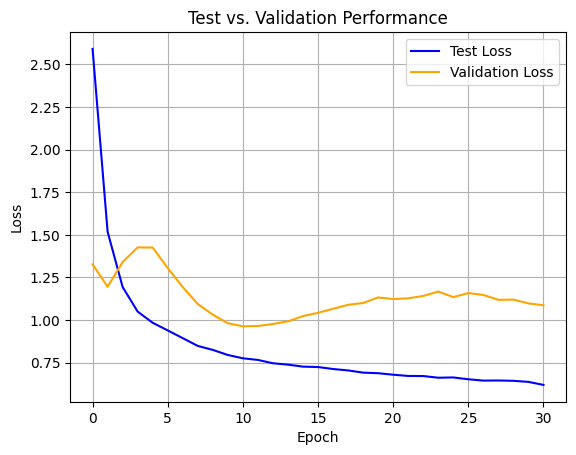

Train indices from 0 to 33572 and validation indices from 33573 to 50358
Epoch [1/100], Loss: 0.8494, Validation Loss: 0.6701, Squareroot of Validation Loss: 0.8186
Epoch [2/100], Loss: 0.8081, Validation Loss: 0.7087, Squareroot of Validation Loss: 0.8418
Epoch [3/100], Loss: 0.7811, Validation Loss: 0.6586, Squareroot of Validation Loss: 0.8115
Epoch [4/100], Loss: 0.7648, Validation Loss: 0.6213, Squareroot of Validation Loss: 0.7882
Epoch [5/100], Loss: 0.7554, Validation Loss: 0.6069, Squareroot of Validation Loss: 0.7790
Epoch [6/100], Loss: 0.7515, Validation Loss: 0.6059, Squareroot of Validation Loss: 0.7784
Epoch [7/100], Loss: 0.7450, Validation Loss: 0.5974, Squareroot of Validation Loss: 0.7729
Epoch [8/100], Loss: 0.7414, Validation Loss: 0.6005, Squareroot of Validation Loss: 0.7749
Epoch [9/100], Loss: 0.7412, Validation Loss: 0.6014, Squareroot of Validation Loss: 0.7755
Epoch [10/100], Loss: 0.7298, Validation Loss: 0.5987, Squareroot of Validation Loss: 0.7737
Epoch 

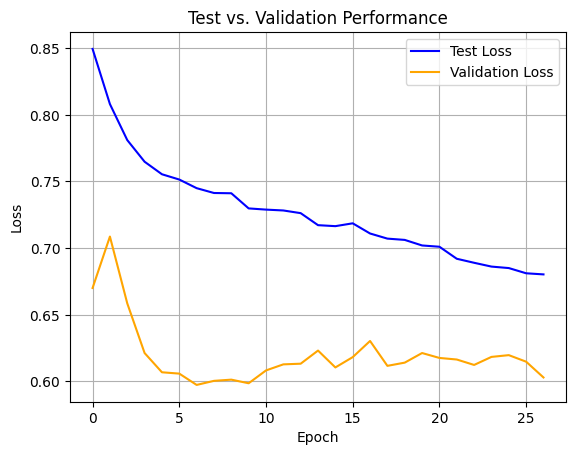

Train indices from 0 to 50358 and validation indices from 50359 to 67144
Epoch [1/100], Loss: 0.6586, Validation Loss: 0.6028, Squareroot of Validation Loss: 0.7764
Epoch [2/100], Loss: 0.6437, Validation Loss: 0.5822, Squareroot of Validation Loss: 0.7630
Epoch [3/100], Loss: 0.6411, Validation Loss: 0.5800, Squareroot of Validation Loss: 0.7616
Epoch [4/100], Loss: 0.6366, Validation Loss: 0.5888, Squareroot of Validation Loss: 0.7673
Epoch [5/100], Loss: 0.6270, Validation Loss: 0.5805, Squareroot of Validation Loss: 0.7619
Epoch [6/100], Loss: 0.6307, Validation Loss: 0.5870, Squareroot of Validation Loss: 0.7662
Epoch [7/100], Loss: 0.6268, Validation Loss: 0.5826, Squareroot of Validation Loss: 0.7633
Epoch [8/100], Loss: 0.6237, Validation Loss: 0.5826, Squareroot of Validation Loss: 0.7633
Epoch [9/100], Loss: 0.6217, Validation Loss: 0.5868, Squareroot of Validation Loss: 0.7660
Epoch [10/100], Loss: 0.6164, Validation Loss: 0.5814, Squareroot of Validation Loss: 0.7625
Epoch 

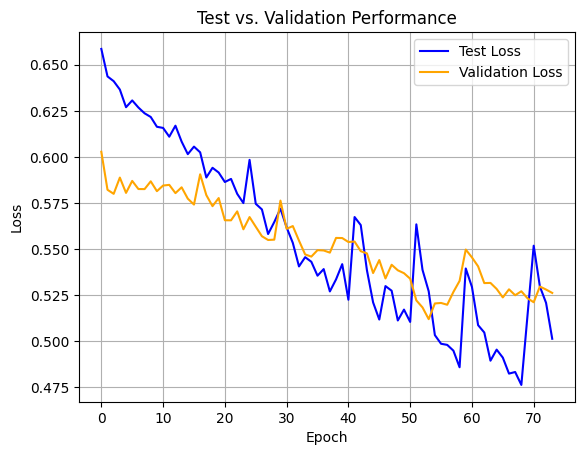

Train indices from 0 to 67144 and validation indices from 67145 to 83930
Epoch [1/100], Loss: 0.5762, Validation Loss: 0.9320, Squareroot of Validation Loss: 0.9654
Epoch [2/100], Loss: 0.5586, Validation Loss: 0.9624, Squareroot of Validation Loss: 0.9810
Epoch [3/100], Loss: 0.5472, Validation Loss: 0.9679, Squareroot of Validation Loss: 0.9838
Epoch [4/100], Loss: 0.5463, Validation Loss: 0.9824, Squareroot of Validation Loss: 0.9912
Epoch [5/100], Loss: 0.5351, Validation Loss: 0.9734, Squareroot of Validation Loss: 0.9866
Epoch [6/100], Loss: 0.5399, Validation Loss: 1.0347, Squareroot of Validation Loss: 1.0172
Epoch [7/100], Loss: 0.5405, Validation Loss: 1.0604, Squareroot of Validation Loss: 1.0298
Epoch [8/100], Loss: 0.5272, Validation Loss: 1.0009, Squareroot of Validation Loss: 1.0004
Epoch [9/100], Loss: 0.5282, Validation Loss: 1.0203, Squareroot of Validation Loss: 1.0101
Epoch [10/100], Loss: 0.5262, Validation Loss: 1.0717, Squareroot of Validation Loss: 1.0352
Epoch 

In [ ]:
from util import training, ElmanRNN

from sklearn.preprocessing import RobustScaler

elman_model_h32 = ElmanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2)

power_elman_h32_results = training(model=elman_model_h32,
                             data=preprocessed_train,
                             batch_size=128,
                             optimizer_learning_rate=0.001,
                             optimizer_weight_decay=1e-4,
                             target_feature_name='Global_active_power',
                             model_name='Power Elman (hidden size 32)',
                             splits=4,
                             patience=20,
                             scaler_X=RobustScaler(),
                             num_epochs=100)


In [ ]:
import pickle

pickle.dump(power_elman_h32_results, open('../models/power_elman_h32_results.pkl', 'wb'))